In [1]:
import tensorflow as tf

print(tf.__version__, tf.config.list_physical_devices())

2025-03-19 13:40:10.509623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-19 13:40:10.532993: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-19 13:40:10.539992: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 13:40:10.557180: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.17.0 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1742391614.073726   98117 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742391614.082561   98117 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742391614.082626   98117 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
from keras.datasets import mnist, boston_housing  # MNIST dataset
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras import models
from keras import layers
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import statistics
import pickle

In [3]:
# val_size_pointer = int(len(X_train)*0.2)
eps = 8
num_of_test = 5


def train_network(
    path: str,
    network_factory,
    max_lay: int,
    unit_list: list,
    X_train,
    y_train,
    X_test,
    y_test,
    l2: bool = False,
):
    logs = dict()
    for num_lay in range(1, max_lay + 1):
        for unit in unit_list:
            for test_time in range(num_of_test):
                num_of_units = int(unit / num_lay)
                log_id = f"l{num_lay}_{num_of_units}_t{test_time}"
                if l2:
                    network = network_factory(num_lay, num_of_units, 1e-3)
                else:
                    network = network_factory(num_lay, num_of_units)
                cp = ModelCheckpoint(
                    filepath=f"{path}/{log_id}.weights.h5",
                    monitor="val_loss",
                    save_best_only=True,
                    save_weights_only=True,
                )
                his = network.fit(
                    X_train,
                    y_train,
                    epochs=eps,
                    batch_size=256,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[cp],
                )
                network.load_weights(f"{path}/{log_id}.weights.h5")
                test_logs = network.evaluate(
                    X_test, y_test, verbose=0, return_dict=True
                )
                logs[log_id] = test_logs
                logs[log_id]["paras"] = network.count_params()

    return logs

## MNIST

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape((-1, 28 * 28)).astype("float32") / 255
X_test = X_test.reshape((-1, 28 * 28)).astype("float32") / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
def mnist_network_factory(lay: int, units: int, l2: float = 0.0):
    network = models.Sequential()
    network.add(layers.Input((28 * 28,)))
    for _ in range(lay):
        if l2:
            network.add(
                layers.Dense(units, activation="relu", kernel_regularizer=l2(l2))
            )
        else:
            network.add(layers.Dense(units, activation="relu"))
    network.add(layers.Dense(10, activation="softmax"))
    network.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return network

In [ ]:
lay_1 = [36, 72, 144, 288, 576, 1152, 2304]
logs = train_network(
    "./weights/Q1/mnist",
    mnist_network_factory,
    3,
    lay_1,
    X_train,
    X_test,
    y_train,
    y_test,
)
pickle.dump(logs, open("q1_mnist_logs.pkl", "wb"))

In [4]:
logs = pickle.load(open("q1_mnist_logs.pkl", "rb"))
logs_df = pd.DataFrame(logs).T
logs_df = logs_df.reset_index()
logs_df["Num of Layers"] = logs_df["index"].str.split("_").str[0].str[1:].astype(int)
logs_df["Units"] = (
    logs_df["index"].str.split("_").str[1].astype(int) * logs_df["Num of Layers"]
)

[None]

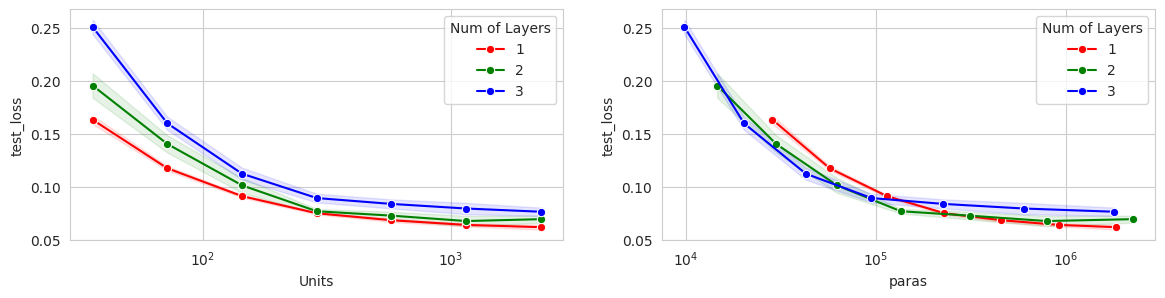

In [7]:
plt.figure(figsize=(14, 3))

plt.subplot(1, 2, 1)
sns.set_style("whitegrid")
fig = sns.lineplot(
    data=logs_df,
    x="Units",
    y="test_loss",
    hue="Num of Layers",
    marker="o",
    errorbar="sd",
    err_kws={"alpha": 0.1},
    palette=sns.color_palette(["red", "green", "blue"]),
)
fig.set(xscale="log")

plt.subplot(1, 2, 2)
sns.set_style("whitegrid")
fig = sns.lineplot(
    data=logs_df,
    x="paras",
    y="test_loss",
    hue="Num of Layers",
    marker="o",
    errorbar="sd",
    err_kws={"alpha": 0.1},
    palette=sns.color_palette(["red", "green", "blue"]),
)
fig.set(xscale="log")

## boston_housing

In [8]:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

m = X_train.mean(axis=0)
s = X_train.std(axis=0)

X_train -= m
X_train /= s

X_test -= m
X_test /= s

In [ ]:
def boston_housing_network_factory(lay: int, units: int, l2: float = 0.0):
    network = models.Sequential()
    network.add(layers.Input((13,)))
    for _ in range(lay):
        if l2:
            network.add(
                layers.Dense(units, activation="relu", kernel_regularizer=l2(l2))
            )
        else:
            network.add(layers.Dense(units, activation="relu"))
    network.add(layers.Dense(1))
    network.compile(
        optimizer="adam",
        loss="mean_squared_error",
        metrics=[
            "mean_absolute_error",
            "root_mean_squared_error",
            "mean_absolute_percentage_error",
        ],
    )
    return network

In [ ]:
lay_1 = [36, 72, 144, 288, 576, 1152, 2304]
logs = train_network(
    "./weights/Q1/boston_housing",
    boston_housing_network_factory,
    3,
    lay_1,
    X_train,
    y_train,
    X_test,
    y_test,
)
pickle.dump(logs, open("q1_boston_housing_logs.pkl", "wb"))

In [9]:
logs = pickle.load(open("q1_boston_housing_logs.pkl", "rb"))
logs_df = pd.DataFrame(logs).T
logs_df = logs_df.reset_index()
logs_df["Num of Layers"] = logs_df["index"].str.split("_").str[0].str[1:].astype(int)
logs_df["Units"] = (
    logs_df["index"].str.split("_").str[1].astype(int) * logs_df["Num of Layers"]
)

[None]

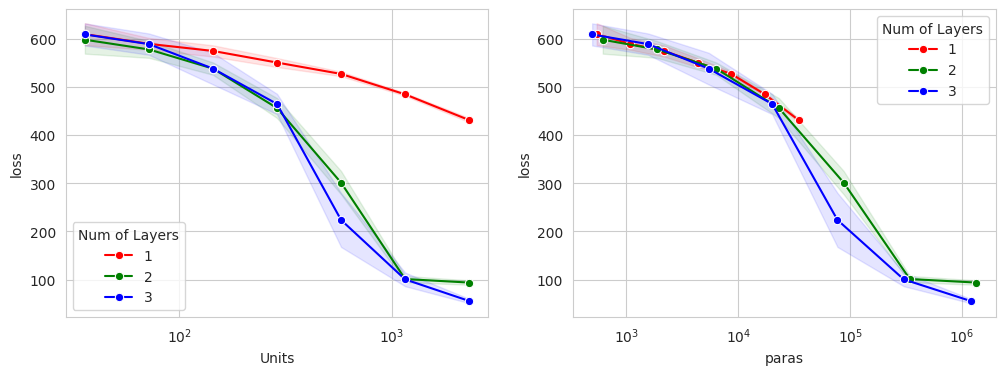

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.set_style("whitegrid")
fig = sns.lineplot(
    data=logs_df,
    x="Units",
    y="loss",
    hue="Num of Layers",
    marker="o",
    errorbar="sd",
    err_kws={"alpha": 0.1},
    palette=sns.color_palette(["red", "green", "blue"]),
)
fig.set(xscale="log")

plt.subplot(1, 2, 2)
sns.set_style("whitegrid")
fig = sns.lineplot(
    data=logs_df,
    x="paras",
    y="loss",
    hue="Num of Layers",
    marker="o",
    errorbar="sd",
    err_kws={"alpha": 0.1},
    palette=sns.color_palette(["red", "green", "blue"]),
)
fig.set(xscale="log")